<a href="https://colab.research.google.com/github/KushiBetaraju/lstm_stock_prediction/blob/main/Copy_of_Stock_Market_Predictions_with_LSTM_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports all libaries available to run the code successfully.

In [5]:
from pandas_datareader import data
import pandas as pd             # To retrieve financial data from various sources.
import matplotlib.pyplot as plt # Data visualization.
import datetime as dt
import urllib.request, json # Retrieving and working with JSON data from APIs.
import os    # Interacting with the operating system.
import numpy as np # Numerical computing
import tensorflow as tf # Building and training machine learning models.
from sklearn.preprocessing  import MinMaxScaler # Transform features by scaling each feature to a given range

# Getting the data

In [6]:

# Read the data
df = pd.read_csv("Training_Data_StockMarket_Prediction_Titan.csv")

# Print the data frame
print(df.to_string())

# Process the data frame columns
col_names = list(df.columns)
# Strip whitespace from column names
for index in range(len(col_names)):
    col_names[index] = col_names[index].rstrip()
df.columns = col_names

# Print the first column name
print(df.columns[0])


            Date      OPEN      HIGH       LOW     close 
0     21-Mar-1997     60.55     64.35     60.55     64.35
1     20-Mar-1997      59.0     60.45      58.3      60.1
2     19-Mar-1997      60.5      60.5      58.5      59.1
3     18-Mar-1997      59.0      59.7      57.4      58.4
4     17-Mar-1997     61.35      61.4      58.5     59.05
5     14-Mar-1997      60.7      62.5      59.6     60.05
6     13-Mar-1997      62.5      62.5      59.6      60.0
7     12-Mar-1997     64.75      64.9      60.0      60.4
8     11-Mar-1997      67.0      67.0      60.5      60.7
9     10-Mar-1997      66.1      66.1     64.25      64.9
10    06-Mar-1997     70.95     70.95      66.5     67.45
11    05-Mar-1997      76.0      76.0      70.3     70.95
12    04-Mar-1997      77.0     77.05      71.5      71.9
13    03-Mar-1997      77.5      80.3      73.0     76.85
14    01-Mar-1997      76.5      79.0      72.0     75.05
15    28-Feb-1997     73.25     74.25      73.0     74.15
16    27-Feb-1

# Data Exploration

In [7]:
# Data Exploration
# sort DataFrame by date
df.sort_values('Date')

# Double check the result
df.head()

,Date,OPEN,HIGH,LOW,close
0,21-Mar-1997,60.55,64.35,60.55,64.35
1,20-Mar-1997,59.0,60.45,58.3,60.1
2,19-Mar-1997,60.5,60.5,58.5,59.1
3,18-Mar-1997,59.0,59.7,57.4,58.4
4,17-Mar-1997,61.35,61.4,58.5,59.05


# Data Visualization

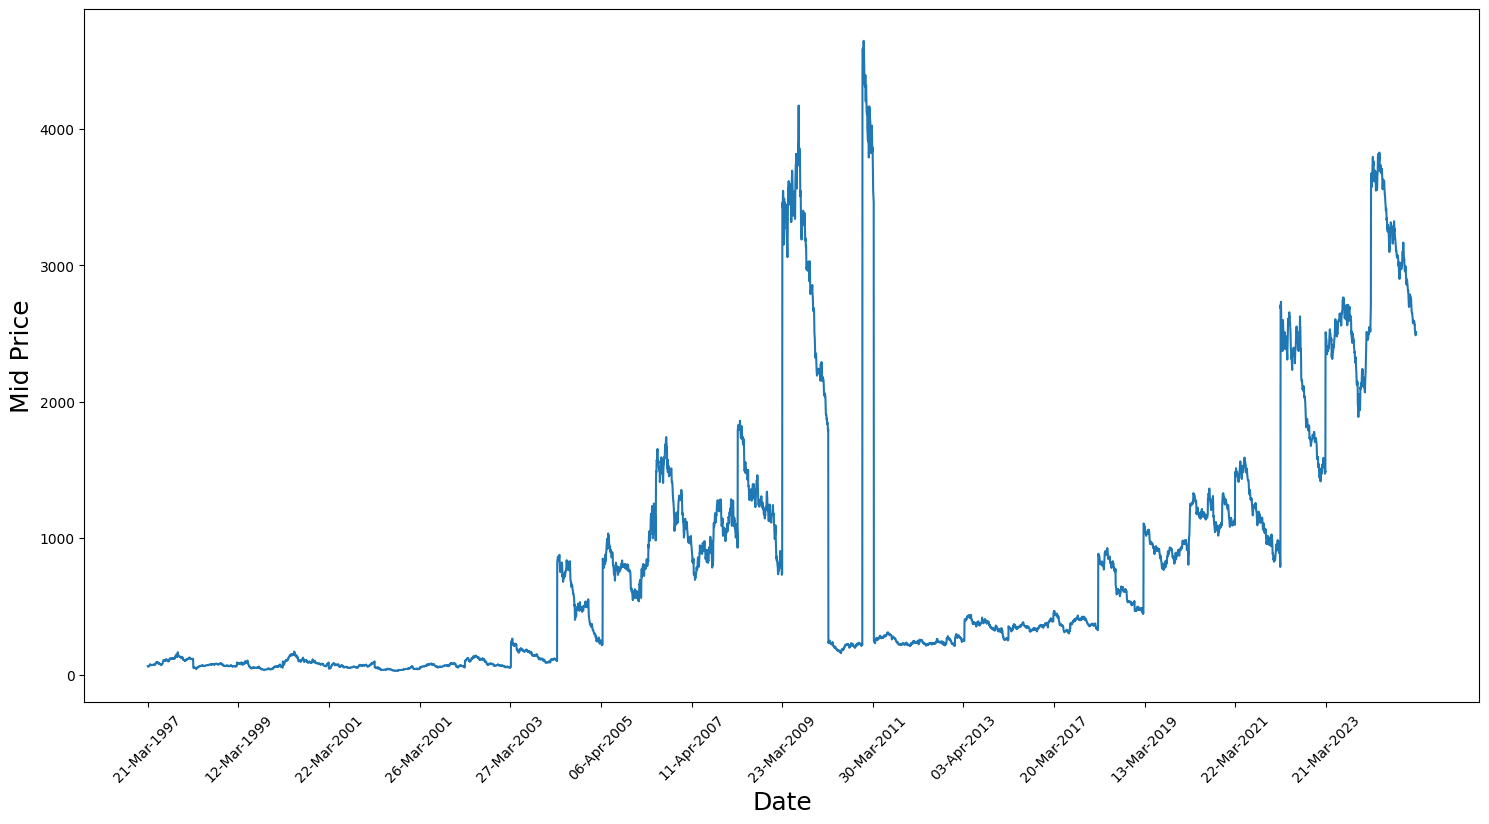

In [8]:
def remove_commas(data):
    """Removes commas from numeric strings (or leaves floats unchanged)."""
    if type(data) == str:  # Check if data is a string
        return data.replace(',', '')  # Remove commas if data is a string
    else:
        return data  # Return the float as it is.

# Remove commas from 'LOW' column
df['LOW'] = df['LOW'].apply(remove_commas)
# Remove commas from 'HIGH' column
df['HIGH'] = df['HIGH'].apply(remove_commas)

# Data Visualization

# Create a figure for the plot
fig = plt.figure(figsize=(18, 9))  # Set the figure size

# Plot the mid price line
plt.plot(range(df.shape[0]), (df['LOW'].astype(float) + df['HIGH'].astype(float)) / 2.0)

# Configure x-axis labels (show dates every 500th data point and rotate for readability)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)

# Set labels for the x-axis and y-axis
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)

# Display the plot
plt.show()


Splitting Data into a Training set and a Test set

In [20]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'HIGH'].astype(float).to_numpy()
low_prices = df.loc[:,'LOW'].astype(float).to_numpy()
mid_prices = (high_prices+low_prices)/2.0

train_data = mid_prices[:6415]
test_data = mid_prices[6415:]


Normalizing the data

In [21]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [22]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 1500
for di in range(0,6000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [25]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)



  Custom normalization function ().

  Args:
      data: The data to be normalized (2D array).
      min_vals: The minimum values used for scaling (1D array).
      max_vals: The maximum values used for scaling (1D array).

  Returns:
      The normalized data (2D array).


In [27]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(6415):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


In [28]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))



MSE error for standard averaging: 0.00918


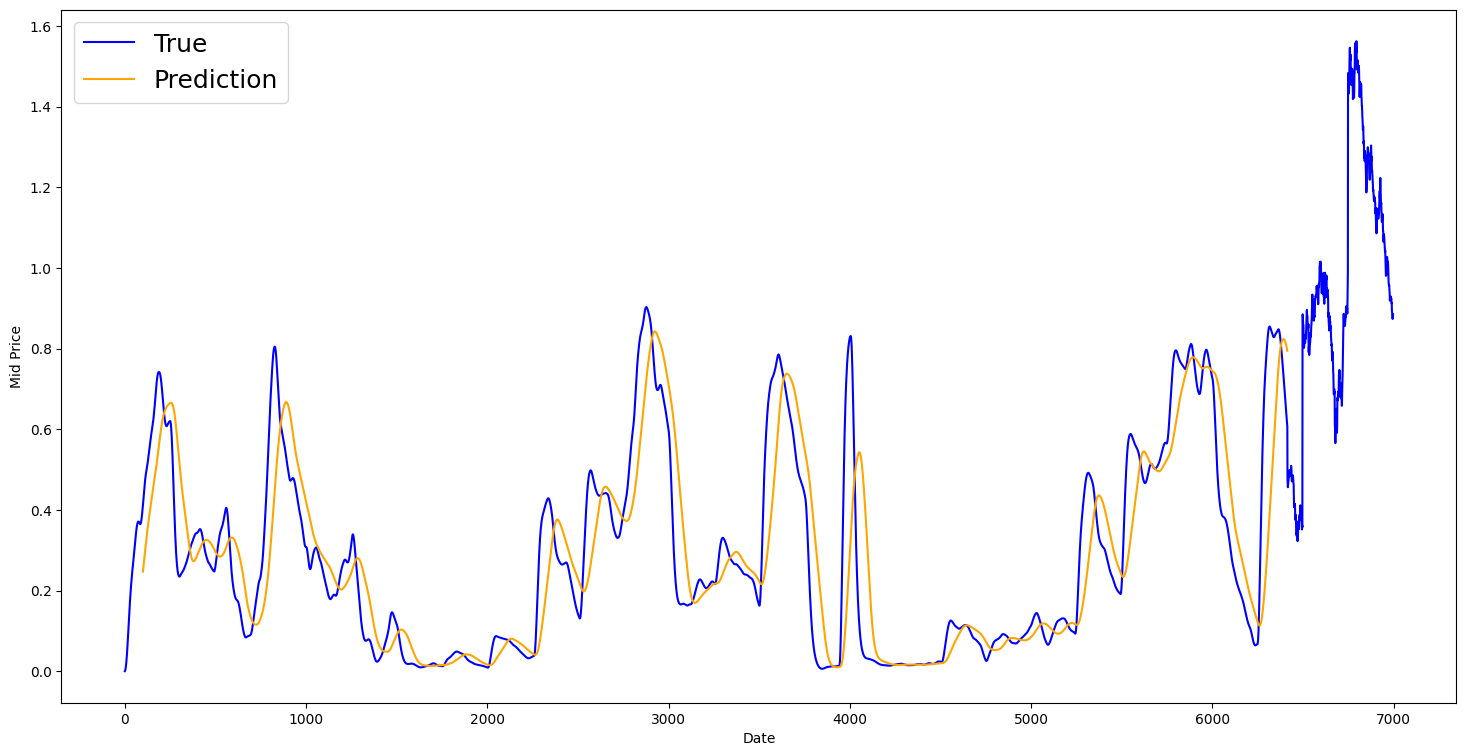

In [29]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [30]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00003


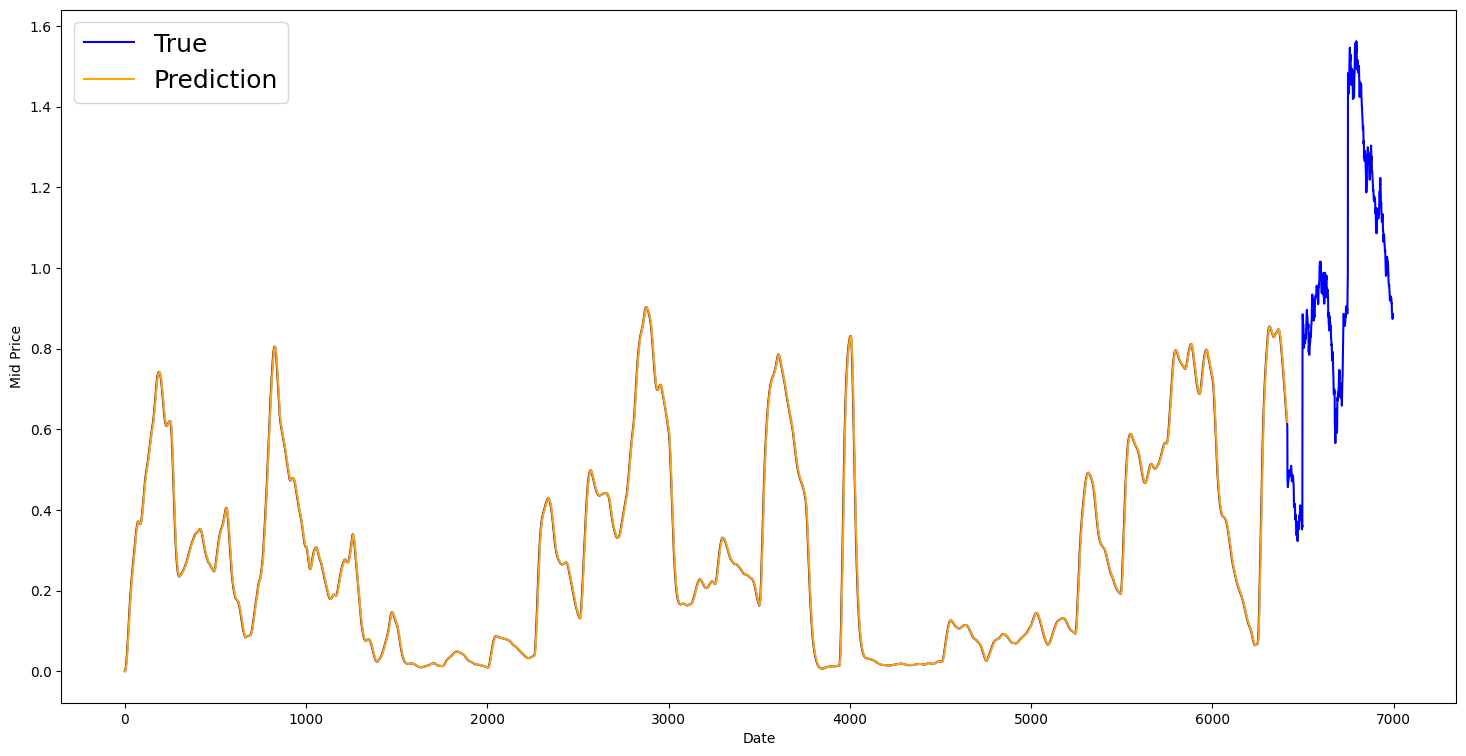

In [31]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [32]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [2.4253137e-04 2.3497228e-01 4.9291879e-01 6.2892335e-03 1.0517385e-01]

	Output: [2.4253137e-04 2.3497228e-01 4.9768755e-01 6.2527577e-03 1.0771971e-01]


Unrolled index 1
	Inputs:  [0.00087562 0.22977076 0.4945185  0.00625746 0.10644913]

	Output: [0.00365456 0.21415189 0.49817947 0.00625746 0.10771971]


Unrolled index 2
	Inputs:  [0.0019965  0.22457273 0.49585396 0.00625276 0.10771971]

	Output: [0.0019965  0.22457273 0.49817947 0.00632476 0.11155035]


Unrolled index 3
	Inputs:  [0.00365456 0.21936327 0.49691084 0.00627545 0.10899437]

	Output: [0.00365456 0.21936327 0.49838844 0.00639887 0.11155035]


Unrolled index 4
	Inputs:  [0.00587898 0.21415189 0.49768755 0.00632476 0.11027459]

	Output: [0.01204893 0.19320385 0.49838844 0.00639887 0.11155035]


In [34]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times

Defining Inputs and Outputs

In [37]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.keras.Input(shape=(batch_size, D), dtype=tf.float32, name='train_inputs_%d' % ui))
    train_outputs.append(tf.keras.Input(shape=(batch_size, 1), dtype=tf.float32, name='train_outputs_%d' % ui))

Defining Parameters of the LSTM and Regression Layer

In [39]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

AttributeError: module 'tensorflow' has no attribute 'contrib'

Calculating LSTM output and feeding it to the regression layer to get final prediction

In [ ]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [ ]:
# help(tf.keras.layers.RNN)
# help(tf.compat.v1.nn.dynamic_rnn)

Loss Calculation and Optimizer

In [ ]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Prediction Related Calculations

In [ ]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)


Running the LSTM

In [ ]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Visualizing the Predictions

In [ ]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()
